# Importing Packages

In [1]:
import pandas as pd 
import numpy as np
import re
import collections
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from nltk.corpus import stopwords
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import LabelEncoder

from keras import models
from keras import layers
from keras import regularizers

Using TensorFlow backend.


# Loading Data

In [2]:
NRows = 10000  # NRows of Dataset

df = pd.read_csv('tweets.csv', encoding = 'latin-1')
df = df.reindex(np.random.permutation(df.index))
df = df.iloc[:,[0, 5]]
df = df.sample(frac=1).reset_index(drop = True)
df = df[:NRows]
df.columns = ["Sentiment", "Tweet"]
df.head()

,Sentiment,Tweet
0,0,http://vibejournal.com/jessica_art/ needs a ne...
1,4,"@SilentBlack0ut Hey Magda! Same over here, was..."
2,0,@SkyMall just landed in Denver! No Wi-Fi on Un...
3,0,Not too much actually
4,0,Whoops! Looks like I'll have to wait it out.


# Preprocessing Tweets

In [3]:
def remove_stopwords(input_text):
    stopwords_list = stopwords.words('english')
    # Some words which might indicate a certain sentiment are kept via a whitelist
    whitelist = ["n't", "not", "no"]
    words = input_text.split() 
    clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
    
    return " ".join(clean_words) 

def remove_specials(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags = re.MULTILINE) # Removing URLs
    text = re.sub(r'@\w+', '', text, flags = re.MULTILINE) # Removing accounts tag(@Ali)
    text = re.sub(r'[^\w\s]', '', text) # Removing Punctuation
    
    return text

df.Tweet = df.Tweet.apply(remove_stopwords).apply(remove_specials)
df.head()

,Sentiment,Tweet
0,0,
1,4,Hey Magda Same here wondering day long till s...
2,0,landed Denver No WiFi United
3,0,Not much actually
4,0,Whoops Looks like Ill wait out


# Splitting & Vectorizing Data

In [4]:
X_train, X_test, y_train, y_test = train_test_split(df.Tweet, df.Sentiment, test_size = 0.2, random_state = 37)

print('Train data samples:', X_train.shape[0])
print('Test data samples:', X_test.shape[0])

Train data samples: 8000
Test data samples: 2000


# Convert Words 2 Numbers

In [5]:
NB_WORDS = 10000  # Indicating the number of words we'll put in the dictionary

tk = Tokenizer(num_words = NB_WORDS, filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower = True, split = " ")
tk.fit_on_texts(X_train)

print('Fitted tokenizer on {} documents'.format(tk.document_count))
print('{} words in dictionary'.format(tk.num_words))
print('Top 5 most common words are:', collections.Counter(tk.word_counts).most_common(5))

Fitted tokenizer on 8000 documents
10000 words in dictionary
Top 5 most common words are: [('im', 892), ('not', 538), ('good', 446), ('day', 431), ('go', 376)]


In [6]:
X_train_seq = tk.texts_to_sequences(X_train)
X_test_seq = tk.texts_to_sequences(X_test)

print('"{}" is converted into {}'.format(X_train.iloc[:1, ], X_train_seq[:1]))

"1846    great day Kendra Heather today
Name: Tweet, dtype: object" is converted into [[46, 4, 2968, 2283, 11]]


In [7]:
def one_hot_seq(seqs, nb_features = NB_WORDS):
    ohs = np.zeros((len(seqs), nb_features))
    for i, s in enumerate(seqs):
        ohs[i, s] = 1.
    return ohs

X_train_oh = one_hot_seq(X_train_seq)
X_test_oh = one_hot_seq(X_test_seq)

print('"{}" is converted into {}'.format(X_train_seq[0], X_train_oh[0]))
print('For this example we have {} features with a value of 1.'.format(X_train_oh[0].sum()))

"[46, 4, 2968, 2283, 11]" is converted into [0. 0. 0. ... 0. 0. 0.]
For this example we have 5.0 features with a value of 1.


# Converting Target Classes 2 Numbers

In [8]:
le = LabelEncoder()
y_train_le = le.fit_transform(y_train)
y_test_le = le.transform(y_test)
y_train_oh = to_categorical(y_train_le)
y_test_oh = to_categorical(y_test_le)

print('"{}" is converted into {}'.format(y_train, y_train_le))
print('"{}" is converted into {}'.format(y_train_le, y_train_oh))

"1846    4
6463    4
7735    0
8493    0
171     4
483     4
1024    0
9300    4
9789    4
8548    0
869     4
3820    0
9386    4
1426    4
5538    4
3361    4
1606    0
6662    0
3471    0
766     0
865     0
6036    4
5629    4
7830    0
5449    4
8810    4
2651    0
7320    4
4190    0
4960    0
       ..
6663    0
7806    0
5279    0
1594    0
2499    4
3417    4
9698    0
7580    4
9011    4
3970    4
5322    4
3825    0
244     4
7832    4
1043    0
2700    0
984     4
4940    4
387     4
1512    0
2015    4
8767    0
3626    4
6595    0
5795    0
4118    0
988     0
9036    4
4459    4
1935    0
Name: Sentiment, Length: 8000, dtype: int64" is converted into [1 1 0 ... 1 1 0]
"[1 1 0 ... 1 1 0]" is converted into [[0. 1.]
 [0. 1.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [1. 0.]]


# Splitting Validation Set

In [9]:
X_train_rest, X_valid, y_train_rest, y_valid = train_test_split(X_train_oh, y_train_oh, test_size = 0.1, random_state = 37)

print('Shape of validation set:', X_valid.shape)

Shape of validation set: (800, 10000)


 # Baseline Model

In [10]:
base_model = models.Sequential()
base_model.add(layers.Dense(64, activation = 'relu', input_shape = (NB_WORDS, )))
base_model.add(layers.Dense(64, activation = 'relu'))
base_model.add(layers.Dense(2, activation = 'softmax'))
base_model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_2 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 130       
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.


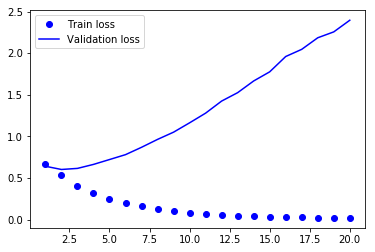

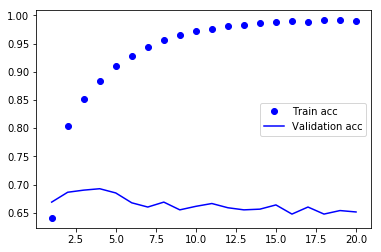

In [11]:
NB_START_EPOCHS = 20  # Number of epochs we usually start to train with
BATCH_SIZE = 512  # Size of the batches used in the mini-batch gradient descent

def deep_model(model):
    model.compile(optimizer = 'rmsprop', loss = 'categorical_crossentropy', metrics = ['accuracy'])
    
    return model.fit(X_train_rest, y_train_rest, epochs = NB_START_EPOCHS, batch_size = BATCH_SIZE, validation_data = (X_valid, y_valid), verbose = 0)

def eval_metric(history, metric_name):
    metric = history.history[metric_name]
    val_metric = history.history['val_' + metric_name]

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, metric, 'bo', label = 'Train ' + metric_name)
    plt.plot(e, val_metric, 'b', label = 'Validation ' + metric_name)
    plt.legend()
    plt.show()

def compare_loss_with_baseline(h, model_name):
    loss_base_model = base_history.history['val_loss']
    loss_model = h.history['val_loss']

    e = range(1, NB_START_EPOCHS + 1)

    plt.plot(e, loss_base_model, 'bo', label='Validation Loss Baseline Model')
    plt.plot(e, loss_model, 'b', label='Validation Loss ' + model_name)
    plt.legend()
    plt.show()

base_history = deep_model(base_model)
eval_metric(base_history, 'loss')
eval_metric(base_history, 'acc')

# Hadeling OverFitting
There are different options to do that.

###### We will add regularization, which comes down to adding a cost to the loss function for large weights.

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 64)                640064    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_6 (Dense)              (None, 2)                 130       
Total params: 644,354
Trainable params: 644,354
Non-trainable params: 0
_________________________________________________________________


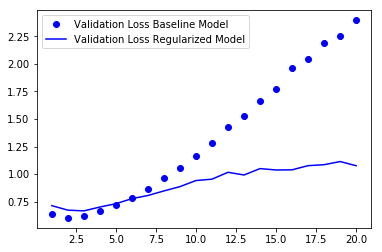

In [12]:
reg_model = models.Sequential()
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu', input_shape=(NB_WORDS,)))
reg_model.add(layers.Dense(64, kernel_regularizer=regularizers.l2(0.001), activation='relu'))
reg_model.add(layers.Dense(2, activation='softmax'))
reg_model.summary()

reg_history = deep_model(reg_model)
compare_loss_with_baseline(reg_history, 'Regularized Model')

# Comparing Models Accuracies

In [13]:
def test_model(model, epoch_stop):
    model.fit(X_train_oh, y_train_oh, epochs = epoch_stop, batch_size = BATCH_SIZE, verbose = 0)
    return model.evaluate(X_test_oh, y_test_oh)

In [14]:
base_results = test_model(base_model, 4)
print('Test accuracy of baseline model: {0:.2f} %'.format(base_results[1] * 100))

2000/2000 [==============================] - 0s 110us/step
Test accuracy of baseline model: 68.75 %


In [15]:
reg_results = test_model(reg_model, 5)
print('Test accuracy of regularized model: {0:.2f} %'.format(reg_results[1] * 100))

2000/2000 [==============================] - 0s 99us/step
Test accuracy of regularized model: 71.95 %
